In [2]:
import skimage.io
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage.filters
import tifffile as tiff
import os

In [5]:
def process_directory(input_dir, output_dir, crop_size=2054):
    total_images_loaded = 0
    total_images_cropped = 0

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.tiff', '.tif')):
                total_images_loaded += 1
                file_path = os.path.join(root, file)

                try:
                    # Load the image
                    image_tiff = tiff.imread(file_path)

                    # Ensure image has exactly 3 layers
                    if image_tiff.shape[0] != 3:
                        print(f"Skipping {file_path}: Image does not have exactly 3 layers.")
                        break

                    # Convert to gray for processing
                    img_gray = image_tiff.mean(axis=0).astype(np.uint8)

                    # Convert to 8-bit format
                    img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

                    # Blur using bilateral filter
                    blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40)
                    t = skimage.filters.threshold_otsu(blur)
                    binary_mask = blur > t
                    binary_mask_normalized = binary_mask.astype(bool)
                    binary_uint8 = np.logical_not(binary_mask_normalized).astype(np.uint8) * 255

                    # Find contours
                    contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    if contours:
                        # Sort contours by area in descending order
                        contours = sorted(contours, key=cv2.contourArea, reverse=True)

                        # The first contour (largest) is the large black mass
                        largest_black_mass = contours[0]

                        # Get the bounding rectangle
                        x, y, w, h = cv2.boundingRect(largest_black_mass)

                        new_x = x + (w - crop_size) // 2  # Center the square box
                        new_y = y + (h - crop_size) // 2  # Center the square box

                        # Ensure new_x, new_y, crop_size are within bounds
                        new_x = max(0, new_x)
                        new_y = max(0, new_y)
                        new_size = min(crop_size, image_tiff.shape[2] - new_x, image_tiff.shape[1] - new_y)

                        if new_size > 0 and new_y + new_size <= image_tiff.shape[1] and new_x + new_size <= image_tiff.shape[2]:
                            # Crop the image
                            cropped_image = image_tiff[:, new_y:new_y + new_size, new_x:new_x + new_size]

                            # Save the cropped image
                            relative_path = os.path.relpath(file_path, input_dir)
                            output_path = os.path.join(output_dir, relative_path)
                            os.makedirs(os.path.dirname(output_path), exist_ok=True)
                            tiff.imwrite(output_path, cropped_image)

                            total_images_cropped += 1
                            print(f"Cropped image saved as {output_path}")
                        else:
                            print(f"Skipping {file_path}: Invalid crop size or coordinates.")
                    else:
                        print(f"Skipping {file_path}: No contours found.")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    print(f"Total images loaded: {total_images_loaded}")
    print(f"Total images cropped: {total_images_cropped}")

# Example usage
input_directory = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\just_test\day10'
output_directory = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\just_test\day10'
process_directory(input_directory, output_directory)


Cropped image saved as C:\Users\k54739\Bibi_new_thesis\thesis\day7_day10\just_test\day10\B04-T01.tiff
Total images loaded: 1
Total images cropped: 1


In [3]:
import os
import tifffile as tiff

def check_image_dimensions(directory, target_height=2054, target_width=2054):
    mismatched_images = []
    total_images_checked = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.tiff', '.tif')):
                file_path = os.path.join(root, file)
                try:
                    image = tiff.imread(file_path)
                    total_images_checked += 1

                    # Check height and width of the first two dimensions
                    if image.shape[1] != target_height or image.shape[2] != target_width or image.shape[0] != 3:
                    
                        mismatched_images.append(file_path)

                except Exception as e:
                    print(f"Error checking image {file_path}: {e}")

    print(f"Total images checked: {total_images_checked}")
    if mismatched_images:
        print("Images with mismatched dimensions:")
        for img in mismatched_images:
            print(f" - {img}")
    else:
        print("All images have the correct dimensions.")

# Example usage
output_directory = r'C:\Users\k54739\Today_data\combined_1259\crop_simclr'
check_image_dimensions(output_directory)


Total images checked: 1254
All images have the correct dimensions.


In [4]:
import os
import shutil
import random

def split_train_val(directory, val_percentage=20):
    train_dir = os.path.join(directory, "train")
    val_dir = os.path.join(directory, "val")

    # Create train and val directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Collect all image paths from the main directory
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.tiff', '.tif')):
                file_path = os.path.join(root, file)
                # Avoid picking files already in train or val
                if "train" not in root and "val" not in root:
                    image_paths.append(file_path)

    # Shuffle and split the data
    random.shuffle(image_paths)
    total_images = len(image_paths)
    val_count = int((val_percentage / 100) * total_images)

    # Move images to validation folder
    val_images = image_paths[:val_count]
    train_images = image_paths[val_count:]

    # Move validation images
    for val_img in val_images:
        relative_path = os.path.relpath(val_img, directory)
        dest_path = os.path.join(val_dir, relative_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.move(val_img, dest_path)

    # Move training images
    for train_img in train_images:
        relative_path = os.path.relpath(train_img, directory)
        dest_path = os.path.join(train_dir, relative_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.move(train_img, dest_path)

    print(f"Total images: {total_images}")
    print(f"Validation images moved: {len(val_images)}")
    print(f"Training images moved: {len(train_images)}")

# Example usage
output_directory = r'C:\Users\k54739\Today_data\combined_1259\crop_simclr'
split_train_val(output_directory, val_percentage=20)


Total images: 1254
Validation images moved: 250
Training images moved: 1004



path = r'C:\Users\k54739\Today_data\combined_1259\Final_simclr\30.tiff'
image = skimage.io.imread(path)


# Convert to gray 
if len(image.shape) == 3: 
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else: 
    img_gray = image

# Convert to 8-bit format
img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


# Blur using bilateral filter
blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40) 
t = skimage.filters.threshold_otsu(blur)
binary_mask = blur > t
binary_mask_normalized = binary_mask.astype(bool)
binary_uint8 = np.logical_not(binary_mask_normalized).astype(np.uint8) * 255

contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area in descending order
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# The first contour (largest) is the large black mass
largest_black_mass = contours[0]

# Get the bounding rectangle
x, y, w, h = cv2.boundingRect(largest_black_mass)

size = 2054
new_x = x + (w - size) // 2  # Center the square box
new_y = y + (h - size) // 2  # Center the square box

image_tiff = tiff.imread(path)
if image_tiff.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

# Ensure that new_x, new_y, size are within bounds
new_x = max(0, new_x)
new_y = max(0, new_y)
new_size = min(size, width - new_x, height - new_y)

# Ensure the crop size and coordinates are valid
if new_size > 0 and new_y + new_size <= image_tiff.shape[1] and new_x + new_size <= image_tiff.shape[2]:
    # Crop the image based on the calculated square dimensions
    if new_x == 0 and new_y == 0:
        high_value = max(image_tiff.shape[1], image_tiff.shape[2])
        if high_value == image_tiff.shape[2]:  # Height is larger
            new_x = int((high_value - new_size) / 2)  # Convert to integer
            new_y = 0  # Ensure no additional offset
        elif high_value == image_tiff.shape[1]:  # Width is larger
            new_y = int((high_value - new_size) / 2)  # Convert to integer
            new_x = 0  # Ensure no additional offset

    # Ensure the slicing indices are integers
    cropped_image = image_tiff[:, int(new_y):int(new_y + new_size), int(new_x):int(new_x + new_size)]  # Including all channels

    # Save the cropped image as a TIFF file
    output_path = r'C:\Users\k54739\cropp_image.tiff'
    tiff.imwrite(output_path, cropped_image)

    print(f"Cropped image saved as {output_path}")
else:
    print("Invalid crop size or coordinates. The cropping box is out of bounds.")

In [ ]:
import skimage.io
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage.filters


path = r'C:\Users\k54739\Today_data\combined_1259\Final_simclr\1130.tiff'
image = skimage.io.imread(path)


# Convert to gray 
if len(image.shape) == 3: 
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else: 
    img_gray = image

# Convert to 8-bit format
img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


# Blur using bilateral filter
blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40) 
t = skimage.filters.threshold_otsu(blur)
binary_mask = blur > t
binary_mask_normalized = binary_mask.astype(bool)
binary_uint8 = np.logical_not(binary_mask_normalized).astype(np.uint8) * 255

with conversion to 8 bit

(2054, 2456, 3)
(2054, 2456)


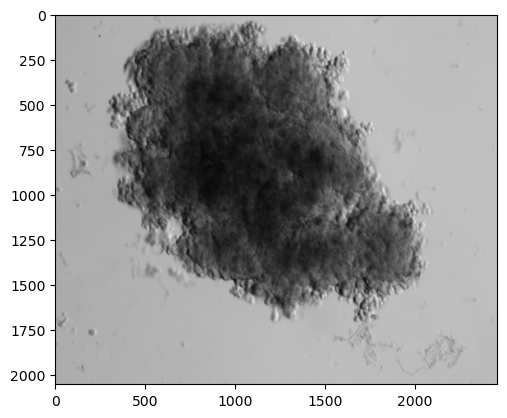

In [750]:
#path = r'C:\Users\k54739\Bibin\thesis\Data_supervised\single_dose\D08-T01.tiff'
path = r'C:\Users\k54739\Today_data\combined_1259\Final_simclr\1130.tiff'
image = skimage.io.imread(path)
print(image.shape)

# Convert to gray 
if len(image.shape) == 3: 
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else: 
    img_gray = image

# Convert to 8-bit format
img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
print(img_gray_8bit.shape)
plt.subplots()
plt.imshow(img_gray_8bit, cmap="gray")



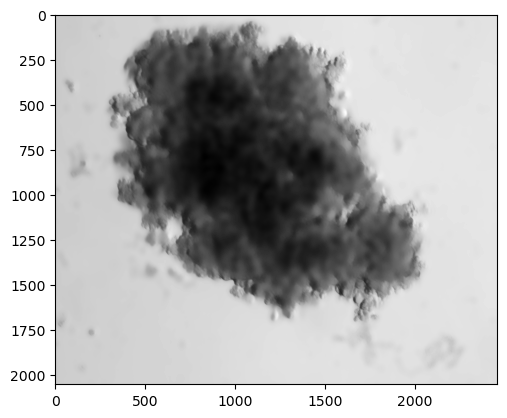

In [751]:
# Blur using bilateral filter
blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40)

plt.subplots()
plt.imshow(blur, cmap="gray")
plt.show()


(0.0, 256.0)

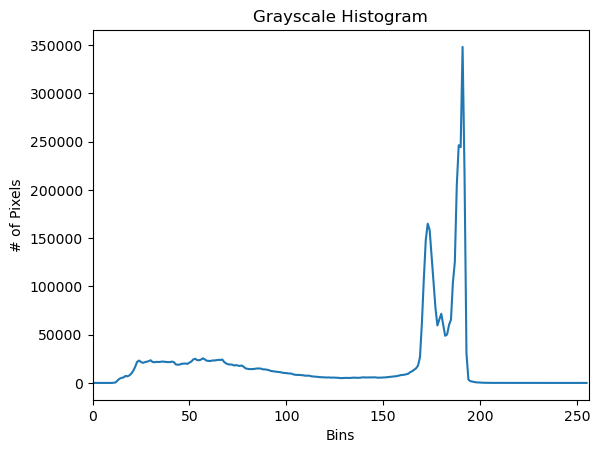

In [752]:
hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
# plot the histogram
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])
#plt.subplots()

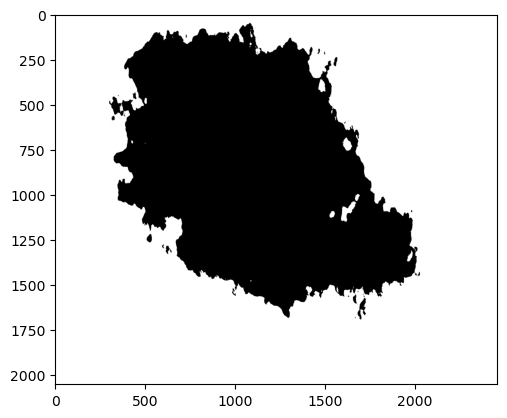

In [753]:
t = skimage.filters.threshold_otsu(blur)
binary_mask = blur > t

plt.subplots()
plt.imshow(binary_mask,cmap="gray")

In [754]:
binary_mask
uniques = np.unique(binary_mask)
print(f"Unique values in binary_mask: {uniques}")

binary_mask_normalized = binary_mask.astype(bool)
unique_values = np.unique(binary_mask_normalized)
print(f"Unique values in normalized binary_mask: {unique_values}")


Unique values in binary_mask: [False  True]
Unique values in normalized binary_mask: [False  True]


binary_uint8 = (~binary_mask_normalized.astype(np.uint8)) * 255  # Invert and scale to [0, 255]
print(binary_uint8)
print(f"Shape: {binary_uint8.shape}")
print(f"Unique values: {np.unique(binary_uint8)}")

In [756]:
binary_uint8 = np.logical_not(binary_mask_normalized).astype(np.uint8) * 255
print(binary_uint8)
unique_values = np.unique(binary_uint8)
print(unique_values)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0 255]


Bounding Box: x=301, y=49, width=1714, height=1638


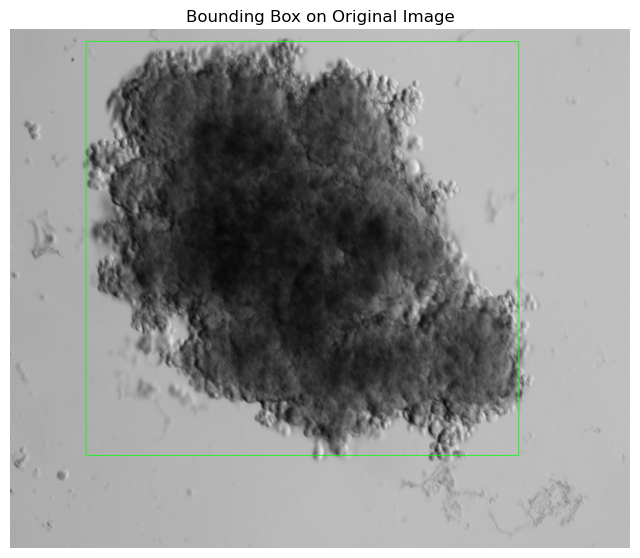

In [757]:
import cv2
# Convert binary_mask to uint8
#binary_uint8 = (~binary_mask_normalized.astype(np.uint8)) * 255  # Invert and scale to [0, 255]

# Find contours
contours, _ = cv2.findContours(binary_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area in descending order
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# The first contour (largest) is the large black mass
largest_black_mass = contours[0]

# Get the bounding rectangle
x, y, w, h = cv2.boundingRect(largest_black_mass)

# Print and optionally display the bounding box
print(f"Bounding Box: x={x}, y={y}, width={w}, height={h}")

import matplotlib.pyplot as plt


# Draw bounding box on the original image
original_image_with_box = cv2.cvtColor(img_gray_8bit, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
cv2.rectangle(original_image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box with thickness 2

# Display using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(original_image_with_box, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title("Bounding Box on Original Image")
plt.axis("off")
plt.show()


In [758]:
print(x)
print(y)
print(w)
print(h)

301
49
1714
1638


In [759]:
#max_value = max(w, h)

#size = max_value + 100
size = 2054

new_x = x + (w - size) // 2  # Center the square box
new_y = y + (h - size) // 2  # Center the square box
print(size)


2054


In [760]:
#if size > max(image.shape[1],image.shape[2]):
    #size = max(image.shape[1],image.shape[2])

In [761]:
print(size)
print(new_x)
print(new_y)

2054
131
-159


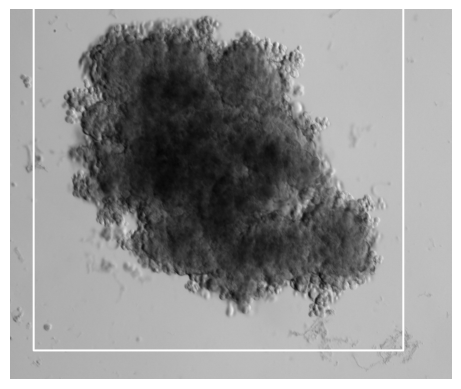

In [762]:
# Draw the rectangle on the image (white color in BGR format)
cv2.rectangle(img_gray_8bit, (new_x, new_y), (new_x + size, new_y + size), (255, 255, 255), thickness=10)

# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
image_rgb = cv2.cvtColor(img_gray_8bit, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()


from skimage.measure import label

labeled_mask = label(binary_mask)
print(f"Number of connected components: {np.max(labeled_mask)}")


from skimage.measure import label
import matplotlib.pyplot as plt

# Label the connected components
labeled_mask = label(binary_mask)

# Visualize the labeled mask
plt.imshow(labeled_mask, cmap='nipy_spectral')  # Each component gets a unique color
plt.title(f"Connected Components: {np.max(labeled_mask)}")
plt.axis("off")
plt.show()


from skimage.measure import regionprops
regions = regionprops(labeled_mask)
for region in regions:
    print(f"Component {region.label}: Area = {region.area}")


from skimage.measure import label, regionprops
import numpy as np
import matplotlib.pyplot as plt

# Label the connected components
labeled_mask = label(binary_mask)

# Get all regions and sort them by area in descending order
regions = regionprops(labeled_mask)
regions_sorted = sorted(regions, key=lambda x: x.area, reverse=True)

# Keep only the top 2 components
top_components = [region.label for region in regions_sorted[:2]]

# Create a new mask containing only the top 2 components
top_2_mask = np.isin(labeled_mask, top_components)

# Visualize the top 2 connected components
plt.imshow(top_2_mask, cmap='nipy_spectral')
plt.title("Top 2 Connected Components by Area")
plt.axis("off")
plt.show()


from skimage.measure import label, regionprops
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Label the connected components
labeled_mask = label(binary_mask)

# Get all regions and sort them by area in descending order
regions = regionprops(labeled_mask)
regions_sorted = sorted(regions, key=lambda x: x.area, reverse=True)

# Keep only the top 2 components
top_components = [region.label for region in regions_sorted[:2]]

# Create a new mask containing only the top 2 components
top_2_mask = np.zeros_like(labeled_mask, dtype=np.int32)
for i, label_value in enumerate(top_components):
    top_2_mask[labeled_mask == label_value] = i + 1  # Assign 1 for the largest and 2 for the second largest

# Create a custom colormap (Red for 1, Blue for 2)
custom_cmap = ListedColormap(['black', 'red', 'blue'])  # Black for background, red for the largest, blue for the second largest

# Visualize the top 2 connected components
plt.imshow(top_2_mask, cmap=custom_cmap)
plt.title("Top 2 Connected Components with Specific Colors")
plt.axis("off")
plt.show()


import cv2
import numpy as np

def find_large_circle_bounding_box(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to get binary image
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # The first contour (largest) is the large circle
    large_circle = contours[0]
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(large_circle)
    
    return x, y, w, h

# Example usage
image_path = r'C:\Users\k54739\Downloads\last.png'
x, y, w, h = find_large_circle_bounding_box(image_path)
print(f"Bounding Box: x={x}, y={y}, width={w}, height={h}")

import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_large_circle_bounding_box(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold to get binary image
    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # The first contour (largest) is the large circle
    large_circle = contours[0]
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(large_circle)
    
    # Draw bounding box on the original image
    result_image = image.copy()
    cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Use matplotlib to display images
    # Convert BGR to RGB for matplotlib
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(result_image_rgb)
    plt.title("Bounding Box")
    plt.axis("off")
    
    plt.show()
    
    return x, y, w, h

# Example usage
image_path = r'C:\Users\k54739\Downloads\last.png'
x, y, w, h = find_large_circle_bounding_box(image_path)
print(f"Bounding Box: x={x}, y={y}, width={w}, height={h}")


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert filtered_mask to uint8
filtered_mask_uint8 = np.asarray(filtered_mask, dtype="uint8")

# Find contours
contours, hierarchy = cv2.findContours(filtered_mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables to track the largest and second-largest bounding boxes
largest_area = 0
second_largest_area = 0
largest_bbox = None
second_largest_bbox = None

# Image dimensions
img_height, img_width = img_gray_8bit.shape[:2]

# Iterate over contours
for c in contours:
    rect = cv2.boundingRect(c)
    x, y, w, h = rect
    area = w * h  # Calculate the area of the bounding box
    
    # Check if this is the largest bounding box
    if area > largest_area:
        # Shift the current largest to second-largest
        second_largest_area = largest_area
        second_largest_bbox = largest_bbox

        # Update the largest
        largest_area = area
        largest_bbox = rect
    elif area > second_largest_area:  # Check if this is the second-largest
        second_largest_area = area
        second_largest_bbox = rect

# Determine the final bounding box
if largest_bbox:
    x, y, w, h = largest_bbox
    if w == img_width and h == img_height:  # If largest box covers the whole image
        final_bbox = second_largest_bbox
    else:
        final_bbox = largest_bbox
else:
    final_bbox = None  # No valid bounding box found

# Draw the final bounding box on the image
if final_bbox:
    x, y, w, h = final_bbox
    cv2.rectangle(img_gray_8bit, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with the final bounding box
plt.subplots()
plt.imshow(img_gray_8bit, cmap="gray")
plt.title("Image with Final Bounding Box")
plt.axis("off")
plt.show()


filtered_mask_uint8= np.asarray(filtered_mask, dtype="uint8")
contours, hierarchy = cv2.findContours(filtered_mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    cv2.rectangle(img_gray_8bit,(x,y),(x+w,y+h),(0,255,0),2)
plt.subplots()
plt.imshow(img_gray_8bit,cmap="gray")


In [28]:
import tifffile as tiff

In [29]:
image_tiff = tiff.imread(path)
image_tiff.shape
pixel_min = np.min(image_tiff)
pixel_max = np.max(image_tiff)

print(f"Range: {pixel_min} - {pixel_max}") 
print(image_tiff.shape)


Range: 10082 - 53164
(3, 2054, 2456)


In [30]:
def count_unique_per_channel(image_tiff):
    unique_counts = []
    for channel in range(image_tiff.shape[0]):  # Loop through each channel (you know it's 3 channels)
        unique_vals = np.unique(image_tiff[channel])
        unique_counts.append(len(unique_vals))
    return unique_counts

# Count unique pixels per channel
unique_per_channel = count_unique_per_channel(image_tiff)

# Print the result
print("Unique pixel counts per channel:")
for i, count in enumerate(unique_per_channel):
    print(f"Channel {i+1}: {count}")

Unique pixel counts per channel:
Channel 1: 2586
Channel 2: 2490
Channel 3: 2431


# Function to plot pixel value distribution by channel
def plot_pixel_value_distribution_by_channel(image_tiff, title, axs, bins=1024):
    for channel in range(image_tiff.shape[0]):
        pixel_values = image_tiff[channel].flatten()  # Flatten to 1D
        axs[channel].hist(pixel_values, bins=bins, range=(0, np.max(pixel_values)), alpha=0.75)
        axs[channel].set_title(f"{title} - Channel {channel+1}")
        axs[channel].set_xlabel('Pixel Value')
        axs[channel].set_ylabel('Count')

# Set up the subplots (3 channels = 3 plots)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot original image pixel value distribution for each channel
plot_pixel_value_distribution_by_channel(image_tiff, 'Original Image Pixel Value Distribution', axs, bins=1024)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [31]:
# Ensure the image has 3 layers (channels)
if image_tiff.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

# Normalize the 16-bit image to [0, 1]
#image = image.astype(np.float32)/65535.0

# Correctly extract the height and width from the shape
no_of_channel = image_tiff.shape[0]
height, width = image_tiff.shape[1], image_tiff.shape[2]
print(image_tiff.shape)
print(f"Height: {height}, Width: {width}")
print(f"no of channels:{no_of_channel}")

(3, 2054, 2456)
Height: 2054, Width: 2456
no of channels:3


# Convert to a torch tensor
image = torch.tensor(image, dtype=torch.float32)
print()
transform = v2.Compose([
    v2.crop([v2.crop,new_y:new_y + size, new_x:new_x + size] ),
])

image_croped = transform(original_image_tensor)

#save cheyth stroiyunnathan presnam enkil border value mathram saviya ennit tiff loadakkumbo transformil kodkka.

In [32]:

# Ensure that new_x, new_y, size are within bounds
new_x = max(0, new_x)
new_y = max(0, new_y)
new_size = min(size, width - new_x, height - new_y)
print(new_x)
print(new_y)
print(new_size)

287
0
2054


In [33]:
new_size > 0

True

In [34]:
image_tiff.shape

(3, 2054, 2456)

In [35]:
image_tiff.shape[1]

2054

In [36]:
new_y + new_size <= image_tiff.shape[1]

True

In [37]:
new_x + new_size <= image_tiff.shape[2]

True

In [38]:
# Ensure the crop size and coordinates are valid
if new_size > 0 and new_y + new_size <= image_tiff.shape[1] and new_x + new_size <= image_tiff.shape[2]:
    # Crop the image based on the calculated square dimensions
    if new_x == 0 and new_y == 0:
        high_value = max(image_tiff.shape[1], image_tiff.shape[2])
        if high_value == image_tiff.shape[2]:  # Height is larger
            new_x = int((high_value - new_size) / 2)  # Convert to integer
            new_y = 0  # Ensure no additional offset
        elif high_value == image_tiff.shape[1]:  # Width is larger
            new_y = int((high_value - new_size) / 2)  # Convert to integer
            new_x = 0  # Ensure no additional offset

    # Ensure the slicing indices are integers
    cropped_image = image_tiff[:, int(new_y):int(new_y + new_size), int(new_x):int(new_x + new_size)]  # Including all channels

    # Save the cropped image as a TIFF file
    output_path = r'C:\Users\k54739\cropp_image.tiff'
    tiff.imwrite(output_path, cropped_image)

    print(f"Cropped image saved as {output_path}")
else:
    print("Invalid crop size or coordinates. The cropping box is out of bounds.")


Cropped image saved as C:\Users\k54739\cropp_image.tiff


In [39]:
print(new_x)
print(new_y)
print(new_size)

287
0
2054


import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Transpose the image to (H, W, C) format if it's in (C, H, W)
if image.shape[0] == 3:  # Assuming 3 channels
    image = image.transpose(1, 2, 0)

# Normalize the image to the range [0, 1] for floats
image = image.astype(np.float32) / 65535.0

# Display the image with the bounding box
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')  # Assuming the image is grayscale; remove cmap for RGB

# Add a rectangle to the plot
rect = patches.Rectangle(
    (new_x, new_y),  # Bottom-left corner of the rectangle
    new_size,        # Width of the rectangle
    new_size,        # Height of the rectangle
    linewidth=2,     # Thickness of the rectangle edges
    edgecolor='red', # Color of the rectangle edges
    facecolor='none' # Transparent fill
)
ax.add_patch(rect)

# Add title and show
plt.title("Image with Bounding Box")
plt.axis("off")
plt.show()


print("image.shape1", image_tiff.shape[1])  # Corrected print statement to properly display the variable
print("image.shape2", image_tiff.shape[2])
print("size", new_size)



if new_x == 0 and new_y == 0:
    high_value = max(image_tiff.shape[1], image_tiff.shape[2])
    print("High Value:", high_value)  # Added label to make the print clearer
    if high_value == image_tiff.shape[2]:  # Height is larger
        new_x = ((high_value - new_size) / 2)
        new_y = 0  # Ensure no additional offset
    elif high_value == image_tiff.shape[1]:  # Width is larger
        new_y = ((high_value - new_size) / 2)
        new_x = 0  # Ensure no additional offset

print("New X:", new_x)  # Added label to make the output clearer
print("New Y:", new_y)


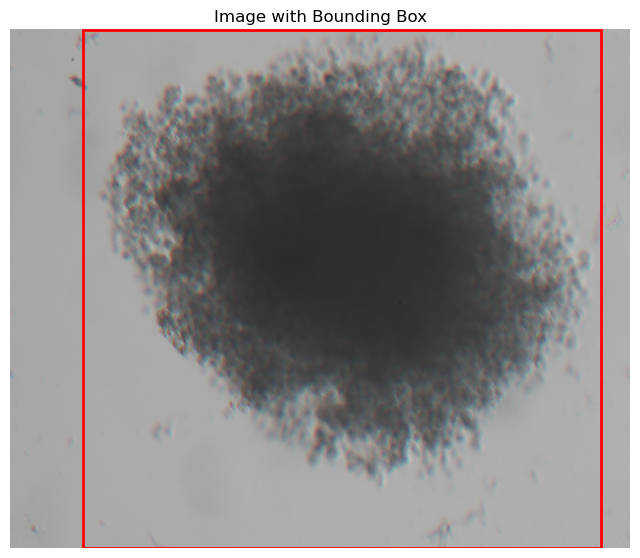

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Transpose the image to (H, W, C) format if it's in (C, H, W)
if image.shape[0] == 3:  # Assuming 3 channels
    image = image.transpose(1, 2, 0)

# Normalize the image to the range [0, 1] for floats
image = image.astype(np.float32) / 65535.0

# Display the image with the bounding box
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')  # Assuming the image is grayscale; remove cmap for RGB

# Add a rectangle to the plot
rect = patches.Rectangle(
    (new_x, new_y),  # Bottom-left corner of the rectangle
    new_size,        # Width of the rectangle
    new_size,        # Height of the rectangle
    linewidth=2,     # Thickness of the rectangle edges
    edgecolor='red', # Color of the rectangle edges
    facecolor='none' # Transparent fill
)
ax.add_patch(rect)

# Add title and show
plt.title("Image with Bounding Box")
plt.axis("off")
plt.show()


if its both x and y are 0 then it won't be centered. need to get into center.


In [81]:
crop_image = tiff.imread(output_path)

In [82]:
# Get the data type (e.g., uint8, uint16, etc.)
data_type = crop_image.dtype

# Get the image height and width
height, width = crop_image.shape[1], crop_image.shape[2]

# Get the range of pixel values
pixel_min = np.min(crop_image)
pixel_max = np.max(crop_image)

# Print the results
print(f"Data Type: {data_type}")
print(f"Height: {height}")
print(f"Width: {width}")
print(f"Range: {pixel_min} - {pixel_max}")
print(crop_image.shape)

Data Type: uint16
Height: 2054
Width: 2054
Range: 8418 - 43562
(3, 2054, 2054)


In [83]:
# Load the 3-channel grayscale image
crop_image = tiff.imread(output_path)

# Count unique pixels per channel
unique_per_channel = count_unique_per_channel(crop_image)

# Print the result
print("Unique pixel counts per channel:")
for i, count in enumerate(unique_per_channel):
    print(f"Channel {i+1}: {count}")

Unique pixel counts per channel:
Channel 1: 2051
Channel 2: 2070
Channel 3: 2093


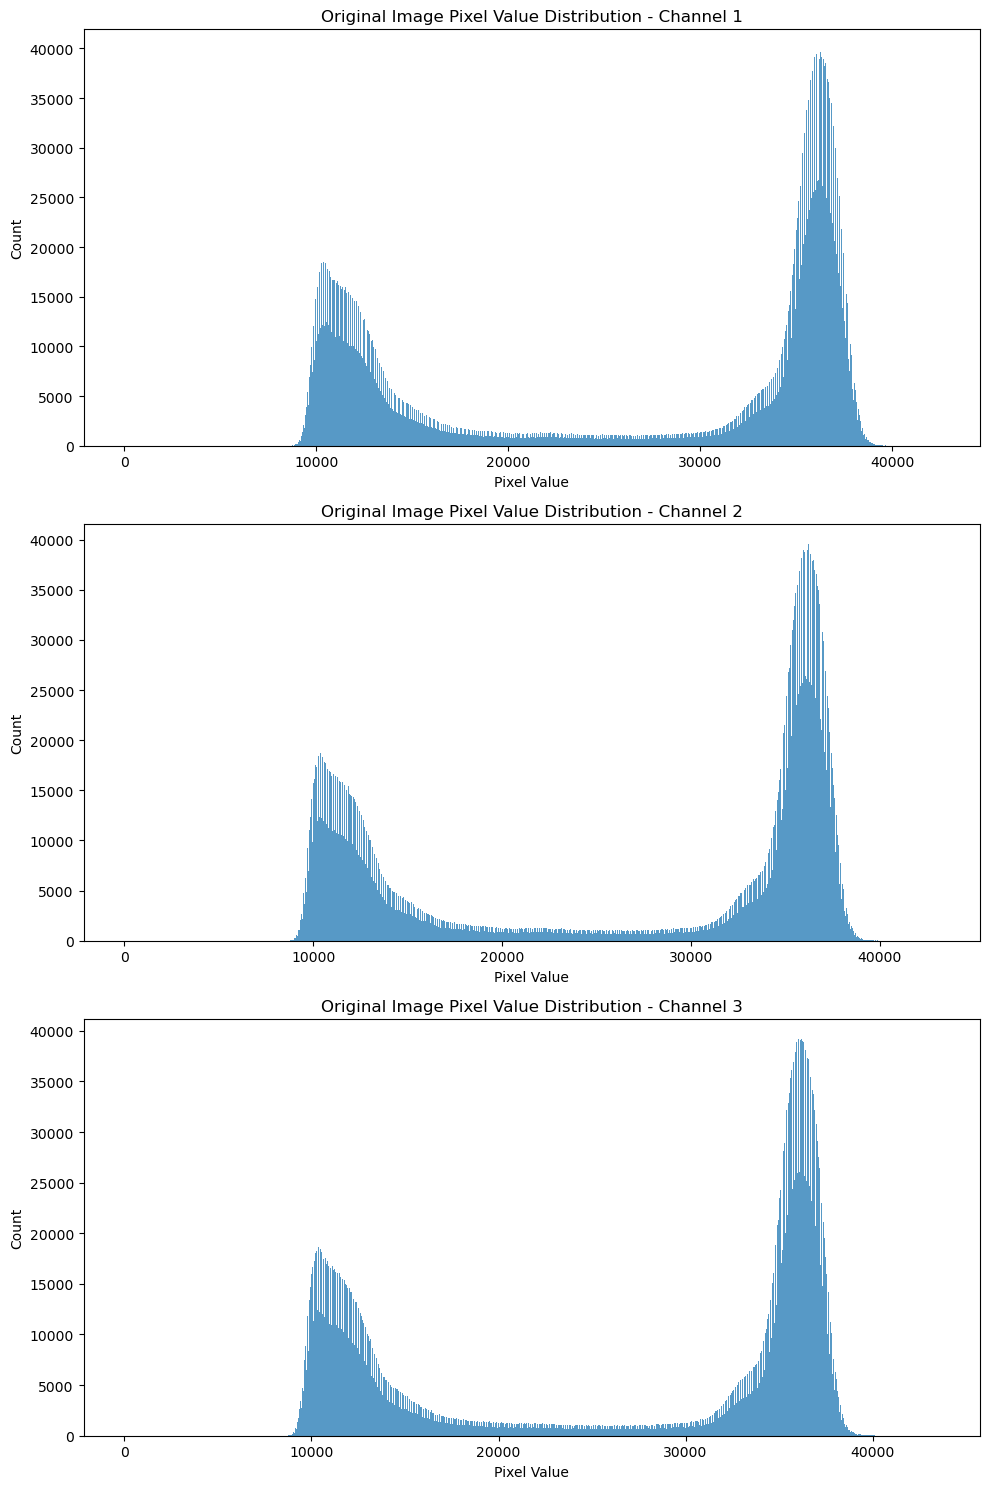

In [84]:



# Load the 3-channel grayscale image
crop_image = tiff.imread(output_path)

# Set up the subplots (3 channels = 3 plots)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot original image pixel value distribution for each channel
plot_pixel_value_distribution_by_channel(crop_image, 'Original Image Pixel Value Distribution', axs, bins=1024)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
